# Question 1

How can census data be leveraged to build a regression model that accurately predicts transportation **cost load** (% of household income that goes to transportation) and what factors within the census data significantly influence transportation costs, thereby aiding in the formulation of cost-effective transportation policies?

### The Plan

The plan is to start from a simplified base linear model and build on top of it, eventually moving to decision tree and ensemble learning methods. 

The main metric we will use is Test MSE, but we will also look at R2 train and R2 test and compare them to gague overfitting. 

### Import libraries and data 

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.features import PCA as PCA_viz
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

from matplotlib import pyplot as plt
%matplotlib inline
seed = 73

In [44]:
df = pd.read_csv('occupied_features_cleaned.csv', index_col = 0)

In [45]:
df.columns

Index(['YRBUILT', 'UNITSIZE', 'RMJOB', 'RMOWNHH', 'RMFAMILY', 'RMCHANGE',
       'RMCOMMUTE', 'RMHOME', 'RMCOSTS', 'RMHOOD', 'RMOTHER', 'NUMPEOPLE',
       'MARKETVAL', 'RATINGNH', 'TOTHCAMT', 'COMDAYS', 'DRIVEALL', 'DIST',
       'INSECURITY', 'load', 'FOUNDTYPE_SINGLEFAM', 'FOUNDTYPE_Uncategorized',
       'BLD_LOWDEN', 'BLD_MIDDEN', 'BLD_MOBILE', 'BLD_SINGLEATTACHED',
       'BLD_SINGLEDETCH', 'BLD_Uncategorized', 'HEATFUEL_COALCOKE',
       'HEATFUEL_ELEC', 'HEATFUEL_FUELOIL', 'HEATFUEL_KEROSENE',
       'HEATFUEL_PIPEDGAS', 'HEATFUEL_SOLAR', 'HEATFUEL_Uncategorized',
       'HEATFUEL_WOOD', 'WATSOURCE_SYSTEM', 'WATSOURCE_Uncategorized',
       'ADEQUACY_MOD_INAD', 'ADEQUACY_SEV_INAD', 'MOVWHY_MOVE_FINANCE',
       'MOVWHY_Uncategorized', 'NRATE_BETTER_NH', 'NRATE_SAME_NH',
       'NRATE_Uncategorized', 'NRATE_WORSE_NH', 'HHRACE_Asian', 'HHRACE_Black',
       'HHRACE_Native', 'HHRACE_Pacific', 'HHRACE_White', 'HHGRAD_B_deg',
       'HHGRAD_Grad_deg', 'HHGRAD_HS', 'HHGRAD_noHS', 'MU

# Split Feature and Target Data, Train and Test Data

In [46]:
X = df.drop(['load','INSECURITY'], axis = 1)
y = df['load']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state = seed) 
print(y_test)

27243    0.185444
39505    0.003081
12995    0.013116
46470    0.016869
42279    0.002808
           ...   
22505    0.021754
39051    0.015058
26854    0.018547
29933    0.010996
1510     0.023843
Name: load, Length: 2490, dtype: float64


## Baseline Model


In [47]:
def linear(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = model.score(X_train, y_train) 
    r2_test = model.score(X_test, y_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print('R2 Train: ', round(r2_train,3))
    print('R2 Test: ', round(r2_test,3))
    print('MSE TRAIN: ', round(mse_train,3))
    print('MSE TEST: ', round(mse_test,3))

    return model, r2_train, r2_test, mse_train, mse_test

model_base, r2_train_base, r2_test_base, mse_train_base, mse_test_base = linear(LinearRegression(), X_train, y_train, X_test, y_test)


R2 Train:  0.426
R2 Test:  0.365
MSE TRAIN:  0.005
MSE TEST:  0.007


## Linear Models with Marginal Improvements 

We're going to add on to the basic linear model incrementally to see if there's an improvement in performance. 
1. Feature Standardization/Normalization 
2. Sequential Selector
3. Lasso Regression 

### Baseline Model with Feature Standardization/Normalization 

In [48]:
# Techinque 1: Standardization 
scaler = StandardScaler()

# Apply the technique to both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [49]:
model_scaled, r2_train_scaled, r2_test_scaled, mse_train_scaled, mse_test_scaled = linear(LinearRegression(), X_train_scaled, 
                                                                                          y_train, X_test_scaled, y_test)



R2 Train:  0.426
R2 Test:  0.368
MSE TRAIN:  0.005
MSE TEST:  0.007


Yes, there is a slight improvement in R2 test and MSE test, meaning we will standardize our data from now on. 

### Baseline Model with Normalization 

In [50]:
# Technique 2: Normalizer()

# Initialize the technique
normalizer = Normalizer()

# Apply the technique to both X_train and X_test
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.fit_transform(X_test)

In [51]:
model_norm, r2_train_norm, r2_test_norm, mse_train_norm, mse_test_norm = linear(LinearRegression(), X_train_norm, 
                                                                                          y_train, X_test_norm, y_test)


R2 Train:  0.15
R2 Test:  0.041
MSE TRAIN:  0.008
MSE TEST:  0.01


Model got worse - don't use normalized data. 

### Linear Model + Sequential Selector

In [52]:
# Initialize SequentialFeatureSelector with LinearRegression as the estimator.
sfs = SequentialFeatureSelector(estimator=LinearRegression(),
                                n_features_to_select='auto',
                                direction = 'forward',
                                scoring = 'neg_mean_squared_error',
                                cv = 10)

# Fit the data to the SFS. 
sfs = sfs.fit(X_train_scaled, y_train)

# Get selected features
feature_names = np.array(df.columns.difference(['load', 'INSECURITY']))
selected_feature_names = feature_names[sfs.get_support()].tolist()
print("Selected features:", selected_feature_names)

# Transform your X_train and X_test to include only the selected features. Hint: use .transform()
X_train_sfs = sfs.transform(X_train_scaled)
X_test_sfs = sfs.transform(X_test_scaled)

# Display the shape of transformed X_train_selected and X_test_selected for verification
print("Transformed X_train shape:",X_train_sfs.shape)
print("Transformed X_test shape:",X_test_sfs.shape)

Selected features: ['ADEQUACY_MOD_INAD', 'ADEQUACY_SEV_INAD', 'BLD_LOWDEN', 'BLD_MOBILE', 'BUS_YES', 'COMTYPE_Driveall', 'COMTYPE_Multimode', 'COMTYPE_Ptall', 'DBMISSMORT_NotReported', 'DBMISSMORT_ON_TIME', 'DISHH_2.0', 'DIST', 'DRIVEALL', 'GARAGE_NotReported', 'HEATFUEL_COALCOKE', 'HEATFUEL_PIPEDGAS', 'HHGRAD_HS', 'HHRACE_Native', 'HHRACE_White', 'MOVWHY_MOVE_FINANCE', 'MOVWHY_Uncategorized', 'MULTIGEN_NotMulti', 'NHQPUBTRN_GoodTranp', 'NHQSCHOOL_NotReported', 'NRATE_BETTER_NH', 'NRATE_SAME_NH', 'NRATE_Uncategorized', 'NUMPEOPLE', 'RENTCNTRL_Uncategorized', 'RMCHANGE', 'RMCOMMUTE', 'RMCOSTS', 'RMHOME', 'SUBSIDY_None', 'SUBSIDY_NotReported', 'SUBSIDY_Partial', 'VAN_Yes', 'WATSOURCE_SYSTEM', 'YRBUILT']
Transformed X_train shape: (9960, 39)
Transformed X_test shape: (2490, 39)


In [53]:
model_sfs, r2_train_sfs, r2_test_sfs, mse_train_sfs, mse_test_sfs = linear(LinearRegression(), X_train_sfs, 
                                                                                          y_train, X_test_sfs, y_test)

coef_dict = {}
for coef, feat in zip(model_sfs.coef_,X_train.columns.to_list()):
    coef_dict[feat] = coef

coef_lr = pd.DataFrame.from_dict(coef_dict, orient = 'index', columns = ['LM_Coefficient'])
print(coef_lr)

R2 Train:  0.344
R2 Test:  0.278
MSE TRAIN:  0.006
MSE TEST:  0.008
                         LM_Coefficient
YRBUILT                       -0.002123
UNITSIZE                      -0.002835
RMJOB                          0.013088
RMOWNHH                       -0.010792
RMFAMILY                       0.009086
RMCHANGE                      -0.011175
RMCOMMUTE                     -0.009935
RMHOME                        -0.002330
RMCOSTS                       -0.002698
RMHOOD                        -0.004540
RMOTHER                        0.004376
NUMPEOPLE                      0.015810
MARKETVAL                      0.045224
RATINGNH                      -0.001494
TOTHCAMT                       0.004243
COMDAYS                       -0.000369
DRIVEALL                      -0.000518
DIST                           0.001429
FOUNDTYPE_SINGLEFAM            0.001688
FOUNDTYPE_Uncategorized        0.001787
BLD_LOWDEN                     0.001352
BLD_MIDDEN                     0.005262
BLD_MOBILE  

Model got slightly worse but is using less features. However, we're going to use the selected features and compare it to the other models later on. 

### Polynomial Models

It's evident that this problem isn't exactly linear, so let's try polynomial. 

In [13]:
# your code here
degrees = [1,2]

def train_and_evaluate_poly(X_train, X_test, y_train, y_test, deg):
    ## Initialize the object
    polynomial_features = PolynomialFeatures(degree = deg, include_bias = False)

    ## Pass X_train and X_test to get a tranformed version
    X_train_polynomial = polynomial_features.fit_transform(X_train)
    X_test_polynomial = polynomial_features.fit_transform(X_test)

    model_polynomial_regression = LinearRegression()
    model_polynomial_regression.fit(X_train_polynomial, y_train)

    y_pred_train = model_polynomial_regression.predict(X_train_polynomial)
    y_pred_test = model_polynomial_regression.predict(X_test_polynomial)

    ## Evaluation metric 1: r2 values
    r2_train = model_polynomial_regression.score(X_train_polynomial, y_train)
    r2_test = model_polynomial_regression.score(X_test_polynomial, y_test)

    ## Evaluation metric 2: Mean squared error (MSE)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return r2_train, r2_test, mse_train, mse_test

def print_results(results, label):
    print(f"Results for Degree {label}:")
    print(f"  R-squared (Train): {results[0]:.4f}")
    print(f"  R-squared (Test) : {results[1]:.4f}")
    print(f"  MSE (Train)      : {results[2]:.4f}")
    print(f"  MSE (Test)       : {results[3]:.4f}")
    print()

model_results = []
for deg in degrees:
    model_results.append(train_and_evaluate_poly(X_train, X_test, y_train, y_test, deg))
    print_results(model_results[deg-1], deg)

Results for Degree 1:
  R-squared (Train): 0.4235
  R-squared (Test) : 0.3635
  MSE (Train)      : 0.0054
  MSE (Test)       : 0.0067

Results for Degree 2:
  R-squared (Train): 0.8304
  R-squared (Test) : -0.0485
  MSE (Train)      : 0.0016
  MSE (Test)       : 0.0111



It is clear from the negative R2 test for quadratic fit that while this model is not linear, it is also not polynomial. 

### Lasso Regression 

In [54]:
# Lasso Regression 
# Getting 300 values on a logarithmic scale
alphas = np.logspace(-5, 5, 300)

# Iterating through the alphas
lasso_model_coefficients = []
mse_lassos = []
avg_mse_lassos = []

model_lasso = Lasso(max_iter = 100000, tol = 0.1) 

for a in alphas:
    model_lasso.set_params(alpha = a)
    model_lasso.fit(X_train_scaled, y_train)
    mse_lasso = cross_val_score(model_lasso, X_train_scaled, 
                                      y_train, scoring = 'neg_mean_squared_error', cv = 10) 
    
    lasso_model_coefficients.append(model_lasso.coef_)
    mse_lassos.append(mse_lasso)
    avg_mse_lassos.append(np.mean(-mse_lasso))

# Find the lowest value of MSE test value
min_mse_lasso = np.min(avg_mse_lassos)
print("Min MSE Test: ", min_mse_lasso)

# Find the index of the lowest MSE test value (use np.argmin)
min_mse_lasso_index = np.argmin(avg_mse_lassos)
print("Index of Min MSE test: ", min_mse_lasso_index)

# Call alphas with the index of the lowest MSE test value
best_alpha_lasso = alphas[min_mse_lasso_index]
print("Best alpha: ", best_alpha_lasso)

Min MSE Test:  0.006545704373823851
Index of Min MSE test:  83
Best alpha:  0.005969249509970733


In [55]:
model_lasso_best = Lasso(alpha = best_alpha_lasso, max_iter = 100000, tol = 0.1)

model_lasso, r2_train_lasso, r2_test_lasso, mse_train_lasso, mse_test_lasso = linear(model_lasso_best, X_train_scaled, 
                                                                                          y_train, X_test_scaled, y_test)

# Extracting the values of coefficients at the best alpha and adding to df
coef_dict_lasso = {}
for coef, feat in zip(model_lasso.coef_,X_train.columns.to_list()):
    coef_dict_lasso[feat] = coef

coef_lasso = pd.DataFrame.from_dict(coef_dict_lasso, orient = 'index', columns = ['LM_Coefficient'])
print(coef_lasso)

R2 Train:  0.371
R2 Test:  0.332
MSE TRAIN:  0.006
MSE TEST:  0.007
                     LM_Coefficient
YRBUILT                   -0.000000
UNITSIZE                  -0.002262
RMJOB                      0.000000
RMOWNHH                    0.000000
RMFAMILY                   0.000000
...                             ...
SUBSIDY_None               0.000000
SUBSIDY_NotReported       -0.000000
SUBSIDY_Partial           -0.000000
GARAGE_NoGarage            0.002113
GARAGE_NotReported         0.000000

[78 rows x 1 columns]


MSEs are pretty on par with the base linear model and we've managed to reduce dimensionality by a lot. This is good, but we can do better.  

## Decision Tree and Ensemble Learning


Let's now try some ensemble learning methods and tune them step-wise. 

In [16]:
def erm(model_type, X_train, y_train, X_test, y_test, seed):

    # Step 1: Initialize a model object
    if model_type == 'DecisionTreeRegressor':
      model = DecisionTreeRegressor(random_state = seed) 
    elif model_type == 'RandomForestRegressor':
      model = RandomForestRegressor(random_state = seed)
    elif model_type == 'GradientBoostingRegressor':
      model = GradientBoostingRegressor(random_state = seed)
    else:
      print('Please specify the model type')

    # Step 2: Train the model
    model.fit(X_train, y_train)

    # Step 3: Get performance metrics
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = model.score(X_train, y_train) 
    r2_test = model.score(X_test, y_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print('Initial Run:  ')
    print('R2 Train: ', round(r2_train,3))
    print('R2 Test: ', round(r2_test,3))
    print('MSE Train: ', round(mse_train,3))
    print('MSE Test: ', round(mse_test,3))

    return model, r2_train, r2_test, mse_train, mse_test

def tuning(model_type, X_train, y_train, parameters_list, cv = 5):
    if model_type == 'DecisionTreeRegressor':
      model = DecisionTreeRegressor(random_state = seed) 
    elif model_type == 'RandomForestRegressor':
      model = RandomForestRegressor(random_state = seed)
    elif model_type == 'GradientBoostingRegressor':
      model = GradientBoostingRegressor(random_state = seed)
    else:
      print('Please specify the model type')


    grid_search_model = GridSearchCV(model, parameters_list, scoring = 'neg_mean_squared_error', cv=cv)
    grid_search_model.fit(X_train, y_train)
    print("Best Parameters:", grid_search_model.best_params_)
    model_finetuned = grid_search_model.best_estimator_

    # Get metrics 
    y_pred_train = model_finetuned.predict(X_train)
    r2_train = model_finetuned.score(X_train, y_train) 
    mse_train = mean_squared_error(y_train, y_pred_train)

    print('Performance Results (from GridSearchCV):  ')
    print('R2 Train: ', round(r2_train,3))
    print('MSE Train: ', round(mse_train,3))

    return model_finetuned


def erm_best(model, X_train, y_train, X_test, y_test):

    # Step 2: Train the model
    model.fit(X_train, y_train)

    # Step 3: Get performance metrics
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = model.score(X_train, y_train) 
    r2_test = model.score(X_test, y_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print('Final Results from Tuning:  ')
    print('R2 Train: ', round(r2_train,3))
    print('R2 Test: ', round(r2_test,3))
    print('MSE Train: ', round(mse_train,3))
    print('MSE Test: ', round(mse_test,3))

    return model, r2_train, r2_test, mse_train, mse_test




### Decision Tree Regressor

In [17]:
# Initial Run for Decision Tree Regressor
model_dtr  = erm('DecisionTreeRegressor', X_train_scaled, y_train, X_test_scaled, y_test, seed)


Initial Run:  
R2 Train:  1.0
R2 Test:  0.263
MSE Train:  0.0
MSE Test:  0.008


In [18]:
parameters_list = {
    'max_depth': [None, 5, 10, 15, 20, 50, 100],
    'criterion': ['squared_error', 'absolute_error']
}

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10}
Performance Results (from GridSearchCV):  
R2 Train:  0.911
MSE Train:  0.001
Final Results from Tuning:  
R2 Train:  0.911
R2 Test:  0.359
MSE Train:  0.001
MSE Test:  0.007


Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10}
Performance Results (from GridSearchCV):  
R2 Train:  0.911
R2 Test:  -0.092
MSE Train:  0.001
MSE Test:  0.012

Final Results from Tuning:  
R2 Train:  0.911
R2 Test:  0.359
MSE Train:  0.001
MSE Test:  0.007

In [19]:
parameters_list = {
    'max_depth': [10],
    'criterion': ['absolute_error'],
    'min_samples_split': [20, 30, 40]
}

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.815
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.815
R2 Test:  0.503
MSE Train:  0.002
MSE Test:  0.005


In [20]:
parameters_list = {
    'max_depth': [10],
    'criterion': ['absolute_error'],
    'min_samples_split': [20],
    'min_samples_leaf': [10, 20, 30]
}

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.78
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.78
R2 Test:  0.614
MSE Train:  0.002
MSE Test:  0.004


In [21]:
parameters_list = {
    'max_depth': [10],
    'criterion': ['absolute_error'],
    'min_samples_split': [20],
    'min_samples_leaf': [10],
    'max_features': [None, 'sqrt', 'log2']
}
model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.78
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.78
R2 Test:  0.614
MSE Train:  0.002
MSE Test:  0.004


In [22]:
parameters_list = {
    'max_depth': [10],
    'criterion': ['absolute_error'],
    'min_samples_split': [20],
    'min_samples_leaf': [10],
    'max_features': [None],
    'max_leaf_nodes': [None, 5, 10, 20]}
#     'min_impurity_decrease': [0.0, 0.1, 0.2],
#     'ccp_alpha': [0.0, 0.1, 0.2]
# }

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.78
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.78
R2 Test:  0.614
MSE Train:  0.002
MSE Test:  0.004


In [23]:
parameters_list = {
    'max_depth': [10],
    'criterion': ['absolute_error'],
    'min_samples_split': [20],
    'min_samples_leaf': [10],
    'max_features': [None],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0, 0.1, 0.2]}
#     'ccp_alpha': [0.0, 0.1, 0.2]
# }

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.78
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.78
R2 Test:  0.614
MSE Train:  0.002
MSE Test:  0.004


In [131]:
parameters_list = {
    'max_depth': [10],
    'criterion': ['absolute_error'],
    'min_samples_split': [20],
    'min_samples_leaf': [10],
    'max_features': [None],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'ccp_alpha': [0.0, 0.1, 0.2]
 }

model_dtr_ft = tuning('DecisionTreeRegressor', X_train_scaled, y_train, parameters_list, cv = 5)

model_dtr_best, r2_train_dtr, r2_test_dtr, mse_train_dtr, mse_test_dtr = erm_best(model_dtr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.78
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.78
R2 Test:  0.614
MSE Train:  0.002
MSE Test:  0.004


#### Best Parameters and Results for Decision Tree:

Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 20}
Performance Results (from GridSearchCV):  
R2 Train:  0.78
MSE Train:  0.002
Final Results from Tuning:  
R2 Train:  0.78
R2 Test:  0.614
MSE Train:  0.002
MSE Test:  0.004

Model tuning increased performance significantly. 

The following parameters did not make a significant difference: 
* ccp_alpha
* impurity decrease
* max_leaf_nodes
* max features




### Random Forest

In [133]:
# RandomForest
model_rfr = erm('RandomForestRegressor', X_train_scaled, y_train, X_test_scaled, y_test, seed)

Initial Run:  
R2 Train:  0.97
R2 Test:  0.614
MSE Train:  0.0
MSE Test:  0.004


In [135]:
parameters_list = {
    'criterion': ['squared_error', 'absolute_error'],  # Function to measure the quality of a split
}

model_rfr_ft = tuning('RandomForestRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_rfr_best, r2_train_rfr, r2_test_rfr, mse_train_rfr, mse_test_rfr = erm_best(model_rfr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error'}
Performance Results (from GridSearchCV):  
R2 Train:  0.97
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.97
R2 Test:  0.641
MSE Train:  0.0
MSE Test:  0.004


Best Parameters: {'criterion': 'absolute_error'}

Performance Results (from GridSearchCV):  
R2 Train:  0.97
MSE Train:  0.0

Final Results from Tuning:  
R2 Train:  0.97
R2 Test:  0.641
MSE Train:  0.0
MSE Test:  0.004

In [136]:
parameters_list = {
    'criterion': ['absolute_error'],  # Function to measure the quality of a split
    'max_depth': [5, 10, 15]  # Maximum depth of the trees
}

model_rfr_ft = tuning('RandomForestRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_rfr_best, r2_train_rfr, r2_test_rfr, mse_train_rfr, mse_test_rfr = erm_best(model_rfr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 15}
Performance Results (from GridSearchCV):  
R2 Train:  0.968
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.968
R2 Test:  0.646
MSE Train:  0.0
MSE Test:  0.004


Best Parameters: {'criterion': 'absolute_error', 'max_depth': 15}

Performance Results (from GridSearchCV):  
R2 Train:  0.968
MSE Train:  0.0

Final Results from Tuning:  
R2 Train:  0.968
R2 Test:  0.646
MSE Train:  0.0
MSE Test:  0.004

In [169]:
parameters_list = {
    'criterion': ['absolute_error'],  # Function to measure the quality of a split
    'max_depth': [15],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]
}

model_rfr_ft = tuning('RandomForestRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_rfr_best, r2_train_rfr, r2_test_rfr, mse_train_rfr, mse_test_rfr = erm_best(model_rfr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_split': 5}
Performance Results (from GridSearchCV):  
R2 Train:  0.956
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.956
R2 Test:  0.646
MSE Train:  0.0
MSE Test:  0.004


#### Best Parameters and Results for Random Forest:
Best Parameters: {'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_split': 5}
Performance Results (from GridSearchCV):  
R2 Train:  0.956
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.956
R2 Test:  0.646
MSE Train:  0.0
MSE Test:  0.004

Random Forest took a long time to run despite few amount of parameters. We stopped tuning here because the MSE improved from 0.00383 to 0.00373 (very minor difference) after multiple hours. 

Also after tuning, the model improved only slightly. 

### Gradient Boosting

In [137]:
# GradientBoosting
model_gbr  = erm('GradientBoostingRegressor', X_train_scaled, y_train,
                                                                    X_test_scaled, y_test, seed)

Initial Run:  
R2 Train:  0.843
R2 Test:  0.68
MSE Train:  0.001
MSE Test:  0.003


In [166]:
parameters_list = {
    'learning_rate': [0.01, 0.1, 0.2]  # Learning rate shrinks the contribution of each tree
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.2}
Performance Results (from GridSearchCV):  
R2 Train:  0.886
MSE Train:  0.001
Final Results from Tuning:  
R2 Train:  0.886
R2 Test:  0.543
MSE Train:  0.001
MSE Test:  0.005


In [141]:
parameters_list = {
    'learning_rate': [0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7]
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5}
Performance Results (from GridSearchCV):  
R2 Train:  0.97
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.97
R2 Test:  0.506
MSE Train:  0.0
MSE Test:  0.005


In [142]:
parameters_list = {
    'learning_rate': [0.2],  
    'max_depth': [5],
    'min_samples_split': [2, 5, 10]
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 10}
Performance Results (from GridSearchCV):  
R2 Train:  0.965
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.965
R2 Test:  0.5
MSE Train:  0.0
MSE Test:  0.005


In [143]:
parameters_list = {
    'learning_rate': [0.2],  
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 4]
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Performance Results (from GridSearchCV):  
R2 Train:  0.956
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.956
R2 Test:  0.466
MSE Train:  0.0
MSE Test:  0.006


In [154]:
parameters_list = {
    'learning_rate': [0.2],  
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
    'subsample': [0.8, 0.9, 1.0]
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'subsample': 0.8}
Performance Results (from GridSearchCV):  
R2 Train:  0.956
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.956
R2 Test:  0.465
MSE Train:  0.0
MSE Test:  0.006


In [167]:
parameters_list = {
    'learning_rate': [0.2],  
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
    'subsample': [0.8],
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
}

model_gbr_ft = tuning('GradientBoostingRegressor', X_train_scaled, y_train, parameters_list, cv = 5)
model_gbr_best, r2_train_gbr, r2_test_gbr, mse_train_gbr, mse_test_gbr = erm_best(model_gbr_ft, X_train_scaled, y_train, X_test_scaled, y_test)

Best Parameters: {'learning_rate': 0.2, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'subsample': 0.8}
Performance Results (from GridSearchCV):  
R2 Train:  0.956
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.956
R2 Test:  0.465
MSE Train:  0.0
MSE Test:  0.006


#### Best Parameters and Results from GBR:

Best Parameters: {'learning_rate': 0.2, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'subsample': 0.8}
Performance Results (from GridSearchCV):  
R2 Train:  0.956
MSE Train:  0.0
Final Results from Tuning:  
R2 Train:  0.956
R2 Test:  0.465
MSE Train:  0.0
MSE Test:  0.006

Model tuning somehow made it worse each time? Not sure what's going on here - might be some instability. 

## Performance Comparison

Let's compile and compare. 

In [170]:
#Create a dictionary to hold evauluation metrics from both models
data = {

    'Model': [
        'Base',
        'Linear + Standardization',
        'Linear + Norm',
        'Linear + Feature Selection',
        'Lasso',
        'Decision Tree', 
        'Random Forest', 
        'Gradient Boosting'], 

    'R2 Train': [
        r2_train_base,
        r2_train_scaled, 
        r2_train_norm,
        r2_train_sfs,  
        r2_train_lasso,
        r2_train_dtr, 
        r2_train_rfr,
        r2_train_gbr],

    'R2 Test': [
        r2_test_base,
        r2_test_scaled, 
        r2_test_norm,
        r2_test_sfs,  
        r2_test_lasso,
        r2_test_dtr, 
        r2_test_rfr,
        r2_test_gbr],
   
    'MSE Train': [
        mse_train_base,
        mse_train_scaled, 
        mse_train_norm,
        mse_train_sfs,  
        mse_train_lasso,
        mse_train_dtr, 
        mse_train_rfr,
        mse_train_gbr],
    
    'MSE Test': [
        mse_test_base,
        mse_test_scaled, 
        mse_test_norm,
        mse_test_sfs,  
        mse_test_lasso,
        mse_test_dtr, 
        mse_test_rfr,
        mse_test_gbr]

    }

# Create and display a dataframe
df = pd.DataFrame(data)
df.to_csv('Q1_model_performance_results.csv')
df


,Model,R2 Train,R2 Test,MSE Train,MSE Test
0,Base,0.423501,0.363456,0.005365,0.006730
1,Linear + Standardization,0.423501,0.365976,0.005365,0.006703
2,Linear + Norm,0.148524,0.048244,0.007924,0.010063
3,Linear + Feature Selection,0.338571,0.276361,0.006155,0.007651
4,Lasso,0.370123,0.330859,0.005861,0.007075
5,Decision Tree,0.779897,0.614243,0.002048,0.004079
6,Random Forest,0.956367,0.646495,0.000406,0.003738
7,Gradient Boosting,0.955850,0.464556,0.000411,0.005661


In [58]:
# I saved the results so I don't have to re-run all the models. 
df = pd.read_csv('Q1_model_performance_results.csv', index_col = 0)
df

,Model,R2 Train,R2 Test,MSE Train,MSE Test
0,Base,0.423501,0.363456,0.005365,0.006730
1,Linear + Standardization,0.423501,0.365976,0.005365,0.006703
2,Linear + Norm,0.148524,0.048244,0.007924,0.010063
3,Linear + Feature Selection,0.338571,0.276361,0.006155,0.007651
4,Lasso,0.370123,0.330859,0.005861,0.007075
5,Decision Tree,0.779897,0.614243,0.002048,0.004079
6,Random Forest,0.956367,0.646495,0.000406,0.003738
7,Gradient Boosting,0.955850,0.464556,0.000411,0.005661


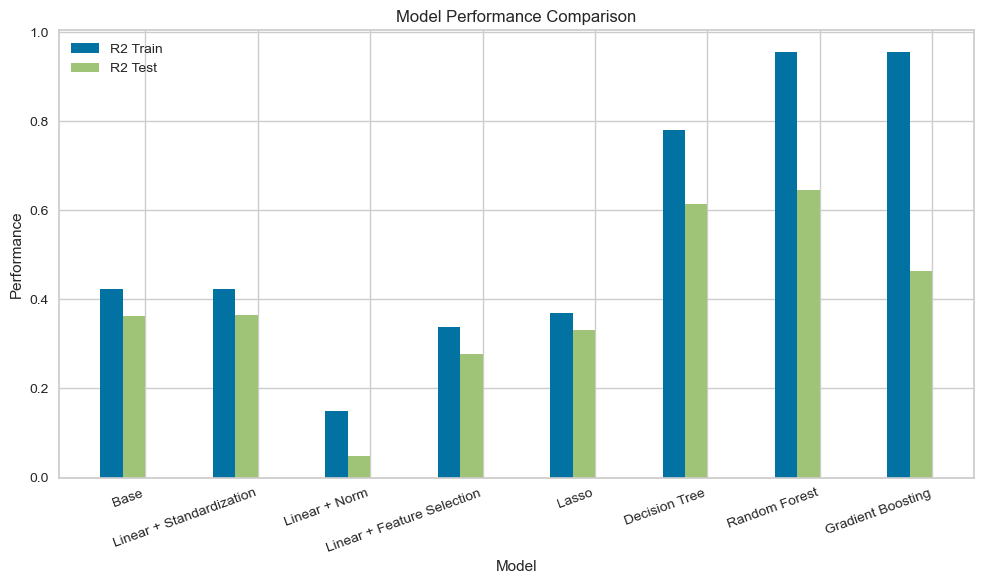

In [60]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Formatting 
num_obs = len(df)
bar_width = 0.2
index = range(num_obs)

# Plotting R2 Train
ax.bar(index, df['R2 Train'], bar_width, label='R2 Train', color='b')

# Plotting R2 Test
ax.bar([i + bar_width for i in index], df['R2 Test'], bar_width, label='R2 Test', color='g')

# Set the x-axis ticks and labels
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(df['Model'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=20, ha='right')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Performance')
ax.set_title('Model Performance Comparison')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


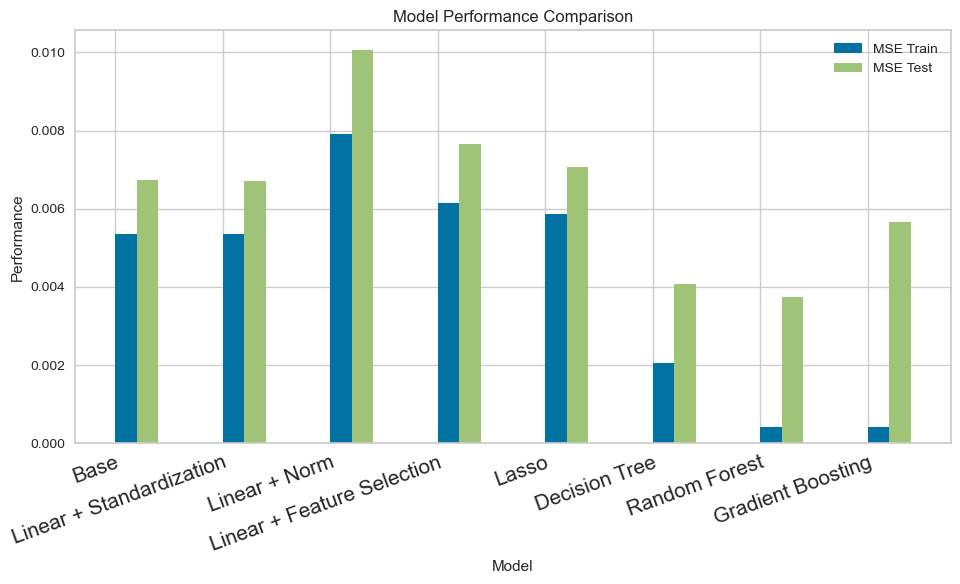

In [42]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Formatting
num_obs = len(df)
bar_width = 0.2
index = range(num_obs)

# Plotting MSE Train
ax.bar([i + 2 * bar_width for i in index], df['MSE Train'], bar_width, label='MSE Train', color='b')

# Plotting MSE Test
ax.bar([i + 3 * bar_width for i in index], df['MSE Test'], bar_width, label='MSE Test', color='g')

# Set the x-axis ticks and labels
ax.set_xticks([i + 1.5 * bar_width for i in index])
ax.set_xticklabels(df['Model'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=20, ha='right')
ax.set_xticklabels(df['Model'], fontsize=15, wrap = True) 

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Performance')
ax.set_title('Model Performance Comparison')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


### Main Model Conclusions

For most of the linear models, aside from the one with normalized data, there did not seem to be much overfitting - the R2 train and test were not extremely dissimilar. As for the decision tree and ensemble learning methods - the R2 train/test were lower for DTR but the differences between R2 train/test were much higher with RFR and GBR. This indicates that RFR and GBR had some overfitting. 

Now, the main decision metric is MSE test, and RFR "wins" in that regard. However, Decision Tree is not far behind - there is only a 10% difference between RFR and DTR MSE tests. Given that the DTR model exhibits less overfitting and better generalizability, as well as higher interpretability, the Decision Tree Model is the final recommended model. 


## Feature Importances 

In [ ]:
def plot_feature_importance(df):    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(df.index, df['LM_Coefficient'], color='skyblue')
    plt.xlabel('Feature Importance (Linear Model Coefficient)')
    plt.ylabel('Features')
    plt.title('Feature Importance Plot')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

### Linear Model + Sequential Feature Selector

In [89]:
coef_lr_nonzero = coef_lr[coef_lr['LM_Coefficient'] != 0]
coef_lr_nonzero.sort_values(by = 'LM_Coefficient', ascending = False, inplace= True)

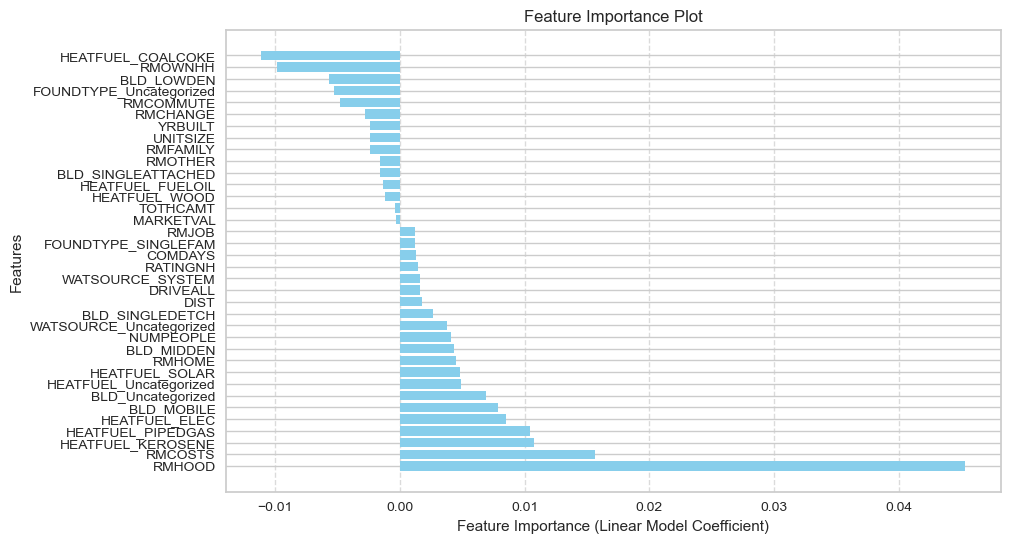

In [90]:
plot_feature_importance(coef_lr_nonzero)

### Lasso 

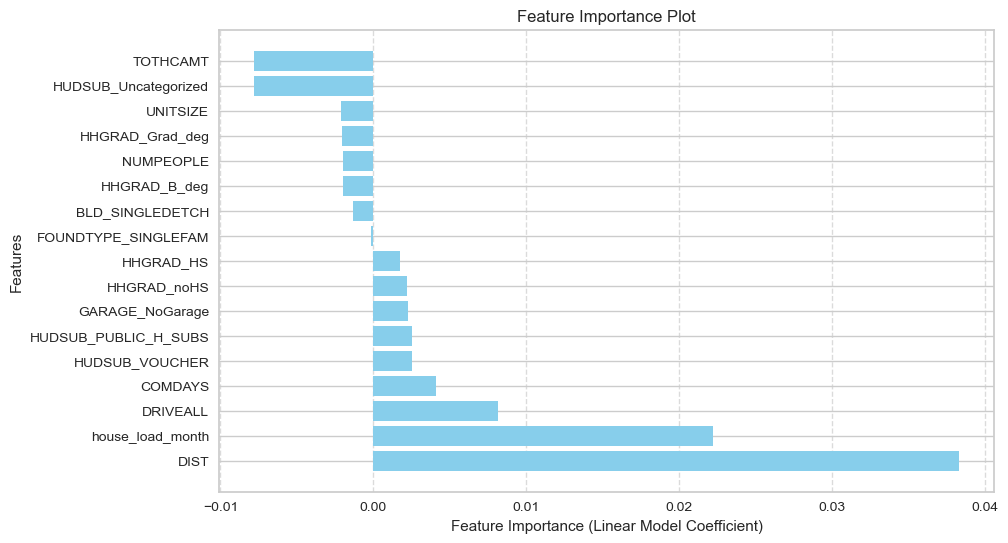

In [93]:
coef_lasso_nonzero = coef_lasso[coef_lasso['LM_Coefficient'] != 0].copy()
coef_lasso_nonzero.sort_values(by = 'LM_Coefficient', ascending = False, inplace= True)

plot_feature_importance(coef_lasso_nonzero)

### Decision Tree

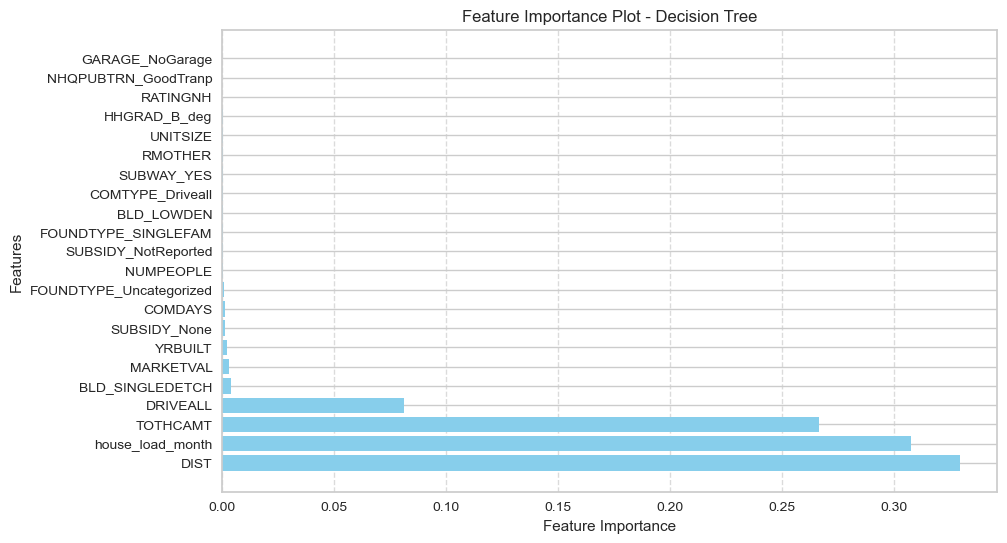

In [165]:
feature_importances = model_dtr_best.feature_importances_

# Get feature names
feature_names = X.columns

data = {
    'Feature Name': feature_names,
    'Importance': feature_importances
     }

df_dtr_features = pd.DataFrame(data)
df_dtr_features_nonzero = df_dtr_features[df_dtr_features['Importance'] != 0].copy()
df_dtr_features_nonzero.sort_values(by = 'Importance', ascending = False, inplace= True)

plt.figure(figsize=(10, 6))
plt.barh(df_dtr_features_nonzero['Feature Name'], df_dtr_features_nonzero['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot - Decision Tree')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The decision tree and lasso shared several features as their most importance - commuting distance (DIST), housing cost load (house_load_month), number of commuting days (DRIVEALL). Lasso had some more subsidy and education related features, which is interesting. 

The linear + sequential feature selector differs significantly in feature selection. It seems to really heavily prioritize household features that should have little/nothing to do with commuting costs. Perhaps that is why it performed poorly. 